<a href="https://colab.research.google.com/github/pparutto/BINF2025_TP8/blob/main/BINF2025_TP8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BINF TP 8 : Genome wide association study

L'étude d'association pangénomique - Genome Wide Association study (GWAS) - est une méthode permettant de mettre en avant des mutations génétiques associées à une condition. Pour cela, on va recruter un ensemble de sujets possédant la condition que l’on souhaite étudier et un ensemble de sujets contrôle "sains". On va ensuite génotyper (ou séquencer) chaque sujet, c’est-à-dire déterminer les nucléotides présents à un ensembles de positions précises le long du génome. Ces positions sont connues pour posséder plusieurs nucléotides différents (des allèles) dans la population humaine qu'on appelle SNP (Single Nucleotide Polymorphism).

Dans ce TP nous allons chercher les gènes associés aux maladies cornariennes - ensemble de maladies où les artères vascularisant le cœur n’arrivent plus à apporter suffisamment de sang pour alimenter les muscles cardiaques. Nous allons utiliser les données de l’étude [PennCath](https://pmc.ncbi.nlm.nih.gov/articles/PMC3335297/). Cette étude comporte 1401 sujets pour lesquels on a génotypé 860473 positions.

Les données sont disponibles [ici](https://www.dropbox.com/scl/fo/tyt6sx74zevblzl4i5lpr/AAJt-WmbWCKmsPuRyzYPfP0?rlkey=yuklfyfy7b93yn2sow0uzuzub&dl=0). Notez que le fichier de génotypage complet avec 1401 patients fait > 2 go, pour faciliter le TP, nous utiliserons un fichier réduit avec seulement 100 patients.

## Exercice 1 : Chargement des données

Les données de l’étude sont divisées en plusieurs fichiers :


* penncath.bim : qui contient les informations sur les positions génotypées (SNPs), une position par ligne avec les colonnes suivantes :
  * Chromosome : pouvant contenir les valeurs 1 – 22, X ou Y.
  * Identifiant de la position dans le génome de référence.
  *	Distance génétique (ignorez cette colonne, elle n’est pas remplie dans le fichier).
  * Position sur le chromosome en paires de bases (on va aussi ignorer cette colonne).
  * Allèle mineure : allèle alternative dans la population (valeurs A,T,G,C ou -9 pour indiquer une absence de données).
  *	Allèle majeure : allèle la plus présente dans la population.

*	penncath.fam : qui contient les informations sur les sujets, une ligne par individu. Dans ce fichier, on s’intéresse uniquement à la première colonne qui contient l’identifiant de la famille.

*	penncath.csv : qui contient des informations cliniques sur les patients, en particulier s’il est atteint de la maladie coronarienne. Ce fichier contient une ligne par patient avec les colonnes suivantes :
   * Id du patient correspondant à la première colonne du fichier fam.
   * Maladie coronarienne : 1=OUI, 0=NON.
   * Les autres colonnes ne nous intéressent pas.

* genotype_small.csv : contient les donnes de génotypage, une colonne par patient, une ligne par position génotypée. Les valeurs sont : 0 : homozygote allèle majeur, 1 : hétérozygote, 2 : homozygote allèle mineure, 3 : génotype manquant.

Chargez les différents fichiers en faisant attention à bien maintenir l’ordre des lignes entre patients et génotypes et associez à chaque patient son statut malade ou sain.

In [2]:
import pandas as pd
import numpy as np

fam = pd.read_csv("penncath.fam", delim_whitespace=True, header=None)
fam.columns = ["ID", "IID", "Father", "Mother", "Sex", "Phenotype"]
patient_ids = fam["ID"]

clinical = pd.read_csv("penncath.csv")
clinical = clinical[["FamID", "CAD"]]
clinical.columns = ["Id", "Maladie_coronarienne"]

clinical["Id"] = clinical["Id"].astype(str)
patient_ids = patient_ids.astype(str)

genotype = pd.read_csv("genotypes_small.csv", header=None, nrows=50)

bim = pd.read_csv("penncath.bim", delim_whitespace=True, header=None)
bim.columns = ["Chromosome", "SNP_ID", "Genetic_Distance", "Position_bp", "Minor_Allele", "Major_Allele"]

/tmp/ipykernel_15203/3622160959.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fam = pd.read_csv("penncath.fam", delim_whitespace=True, header=None)
/tmp/ipykernel_15203/3622160959.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bim = pd.read_csv("penncath.bim", delim_whitespace=True, header=None)


In [ ]:
fam = pd.read_csv("penncath.fam", delim_whitespace=True, header=None)
fam.columns = ["ID", "IID", "Father", "Mother", "Sex", "Phenotype"]
patient_ids = fam["ID"]

In [ ]:
clinical = pd.read_csv("penncath.csv")
clinical = clinical[["FamID", "CAD"]]
clinical.columns = ["Id", "Maladie_coronarienne"]

clinical["Id"] = clinical["Id"].astype(str)
patient_ids = patient_ids.astype(str)

In [ ]:
genotype = pd.read_csv("genotypes_small.csv", header=None, nrows=50)

In [ ]:
bim = pd.read_csv("penncath.bim", delim_whitespace=True, header=None)
bim.columns = ["Chromosome", "SNP_ID", "Genetic_Distance", "Position_bp", "Minor_Allele", "Major_Allele"]

## Exercice 2 : contrôle qualité

Comme on manipule des données brutes, certaines vont être problématiques et on va vouloir les enlever pour éviter de biaiser les résultats. Dans cette exercice, nous allons détecter et filtrer les données problématiques.


1. Vérifions la distribution des données par chromosome. Affichez le nombre de SNP pour chaque chromosome sous la forme d'un barplot (l'axe x représente chaque chromosome et l'axe y le nombre de SNPs correspondant).

In [5]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.7 MB/s eta 0:00:00


/tmp/ipykernel_15203/2963387720.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=snp_counts.index.astype(str), y=snp_counts.values, palette="viridis")


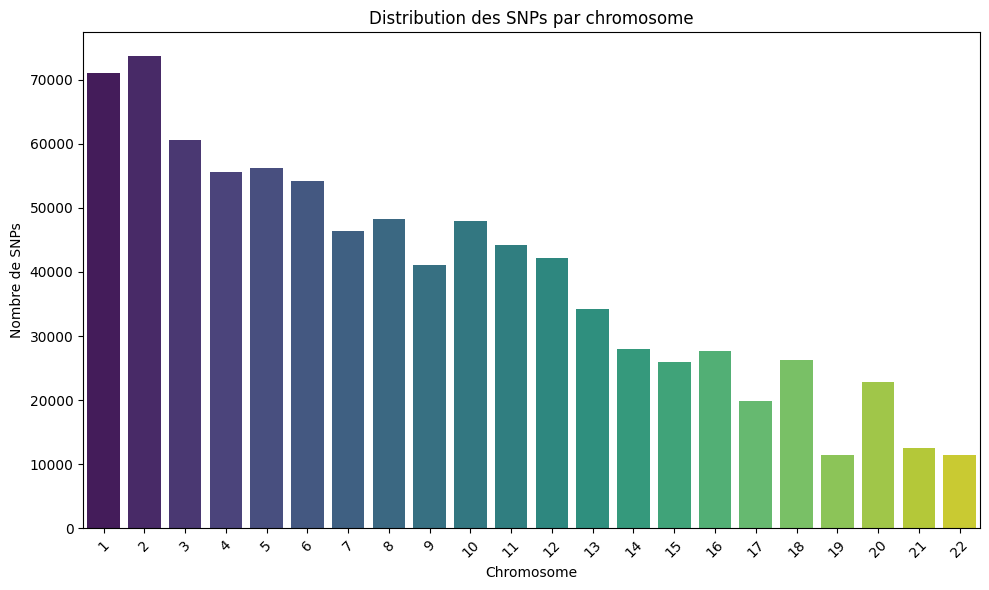

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

snp_counts = bim["Chromosome"].value_counts().sort_index()

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=snp_counts.index.astype(str), y=snp_counts.values, palette="viridis")

plt.xlabel("Chromosome")
plt.ylabel("Nombre de SNPs")
plt.title("Distribution des SNPs par chromosome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Qu’observez-vous ?

**Plus il y a de SNPs, et moins il y a de chromosomes.**

2. Vérifions maintenant les valeurs des allèles. Affichez un barplot comptant la quantité de chaque nucléotide apparaissant dans les allèles mineures (-9 signifie une absence de données, affichez le dans le graphique, c’est important).


0         -9
1          G
2          T
3          C
4          C
          ..
861468     A
861469    -9
861470    -9
861471    -9
861472     G
Name: Minor_Allele, Length: 861473, dtype: object


/tmp/ipykernel_15203/3882525874.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=allele_counts.index, y=allele_counts.values, palette="Set2")


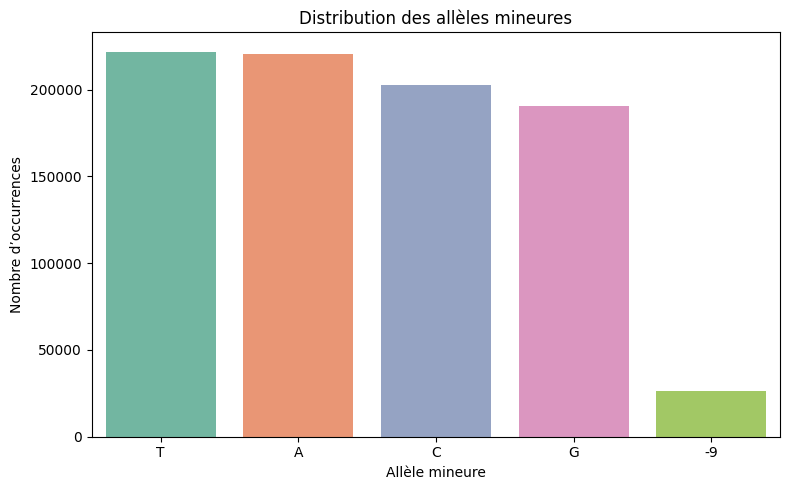

In [11]:
# Compter les fréquences des allèles mineures
allele_counts = bim["Minor_Allele"].value_counts()
print(bim["Minor_Allele"])

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=allele_counts.index, y=allele_counts.values, palette="Set2")

plt.xlabel("Allèle mineure")
plt.ylabel("Nombre d’occurrences")
plt.title("Distribution des allèles mineures")
plt.tight_layout()
plt.show()

3. Faites de même avec les valeurs de l’allèle majeure.

0         C
1         C
2         C
3         T
4         T
         ..
861468    G
861469    A
861470    A
861471    T
861472    A
Name: Major_Allele, Length: 861473, dtype: object


/tmp/ipykernel_15203/3902664063.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=allele_counts.index, y=allele_counts.values, palette="Set2")


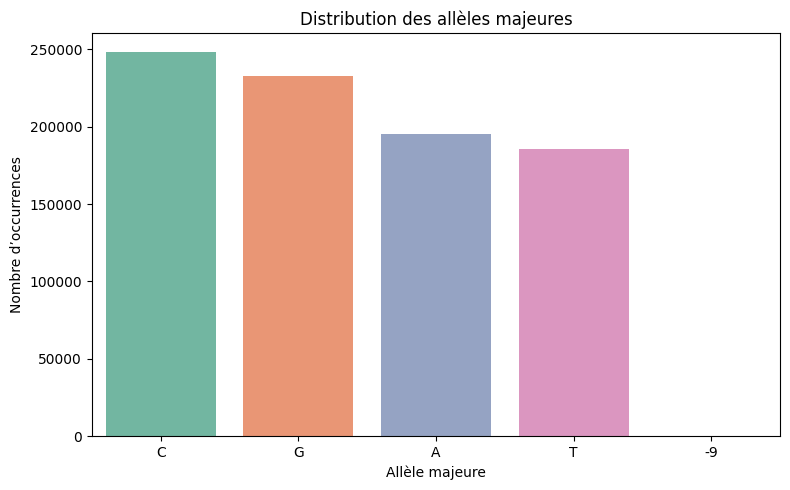

In [12]:
# Compter les fréquences des allèles majeures
allele_counts = bim["Major_Allele"].value_counts()
print(bim["Major_Allele"])

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=allele_counts.index, y=allele_counts.values, palette="Set2")

plt.xlabel("Allèle majeure")
plt.ylabel("Nombre d’occurrences")
plt.title("Distribution des allèles majeures")
plt.tight_layout()
plt.show()

4. Qu’observez-vous en comparant ces deux graphiques ?

**Les allèles majeures ont aucun -9**

5. Intéressons-nous maintenant aux données de génotypage. Dans ces données, une valeur NAN indique qu’il y a eu une erreur au niveau de l'acquisition des données. Affichez l’histogramme du nombre d’erreurs de génotypage par patient (nombre de NAN ou valeurs 4).

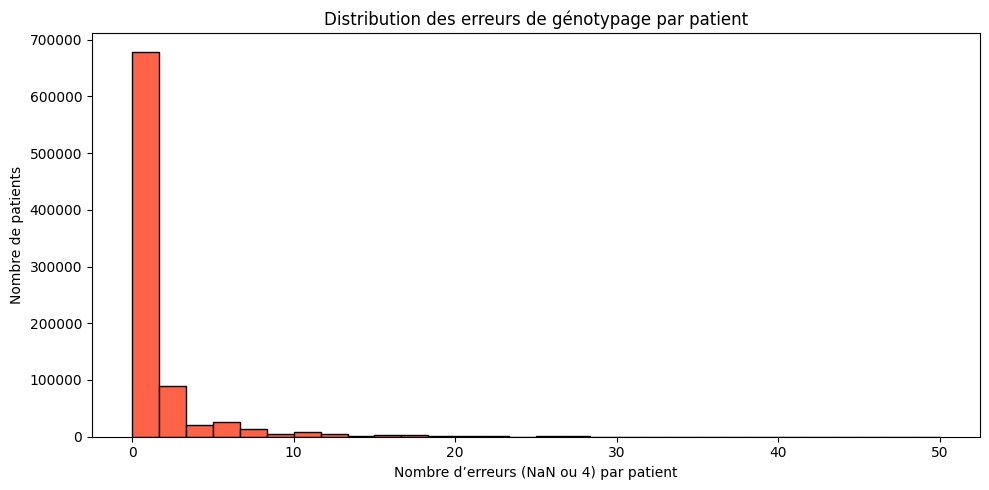

In [13]:
# Remplacer les 4 par NaN si vous préférez travailler uniquement avec des NaN
genotype_clean = genotype.replace(4, np.nan)

# Compter les erreurs (valeurs NaN) par patient (chaque colonne = un patient)
error_counts = genotype_clean.isna().sum(axis=0)

# Afficher l’histogramme
plt.figure(figsize=(10, 5))
plt.hist(error_counts, bins=30, color='tomato', edgecolor='black')
plt.xlabel("Nombre d’erreurs (NaN ou 4) par patient")
plt.ylabel("Nombre de patients")
plt.title("Distribution des erreurs de génotypage par patient")
plt.tight_layout()
plt.show()

6. Affichez l’histogramme du nombre d’erreurs par position de SNP (nombre de NAN ou valeurs 4).

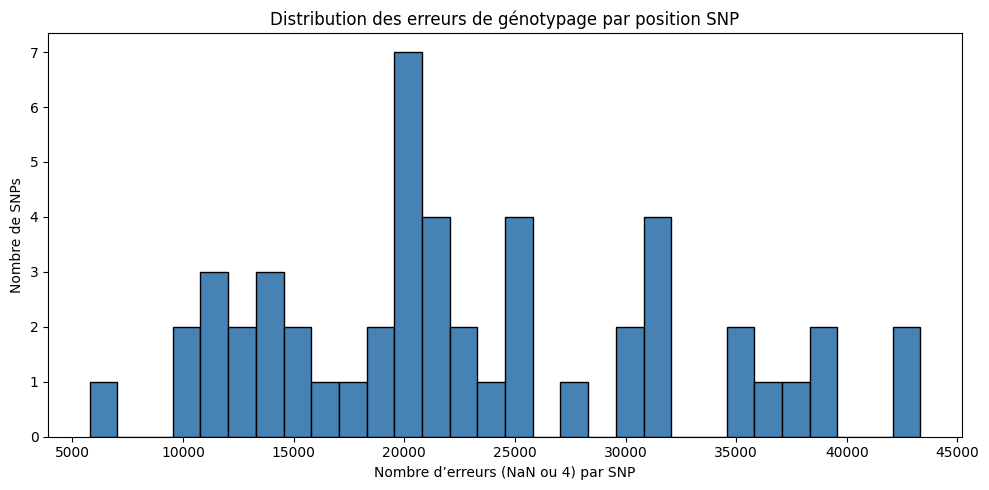

In [14]:
snp_error_counts = ((genotype == 4) | genotype.isna()).sum(axis=1)

# Affichage de l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(snp_error_counts, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Nombre d’erreurs (NaN ou 4) par SNP")
plt.ylabel("Nombre de SNPs")
plt.title("Distribution des erreurs de génotypage par position SNP")
plt.tight_layout()
plt.show()

7. Retirez tous les SNP qui possèdent des valeurs à NaN ainsi que ceux possédant une seule valeur chez tous les patients. Faites attention de garder la liste des caractéristiques des SNP bien synchronisé car nous l’utiliserons pour la dernière question.

In [15]:
genotype_clean = genotype.replace(4, np.nan)

# Étape 1 : retirer les lignes avec au moins un NaN
mask_no_nan = ~genotype_clean.isna().any(axis=1)

# Étape 2 : retirer les lignes constantes (une seule valeur unique)
mask_not_constant = genotype_clean.nunique(axis=1) > 1

# Combiner les deux conditions
mask_final = mask_no_nan & mask_not_constant

# Appliquer le filtre
genotype_filtered = genotype_clean[mask_final].reset_index(drop=True)
bim_filtered = bim[mask_final].reset_index(drop=True)

print("Génotypes filtrés :", genotype_filtered.shape)
print("SNPs restants dans bim :", bim_filtered.shape)


/tmp/ipykernel_15203/256714777.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bim_filtered = bim[mask_final].reset_index(drop=True)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## Exercice 3 : Association

Pour chaque SNP on va calculer sa probabilité d’être sur ou sous-représenté dans la population malade comparé à la population contrôle. Il existe plusieurs méthodes statistiques plus ou moins sophistiquées pour faire celà, nous allons voir la méthode la plus simple utilisant des tableaux de comptes d’allèles.

1. Pour chaque génotype k, construisez le tableau 2x2 suivant O :
$$\begin{array}{|l|ll|}
\hline
& Allele\ mineure & Allele\ majeure\\\hline
sain & a & b\\
malade & c & d\\
\hline
\end{array}$$
où $a,b$ sont les nombres de patients sain possédant l'allèle mineure ou majeure (respectivement) et $c,d$ les nombres de patients malades possédant l'alèlle mineure ou majeure (respectivement), pour le génotype $k$.

In [ ]:
print("Votre code ici !!")

2. 	Pour chaque génotype $k$, calculez une p-value en effectuant un test du $\chi^2$ sur la table $O$ :
$$
z_{ij} = \frac{(o_{ij}-e_{ij})^2}{e_{ij}},
$$
où $o_{ij}$ est la valeure de la case $i,j$ de la table $O$ (la valeure observée) et $e$ la valeur attendue selon l'hypothèse nulle calculée par:
$$e_{ij} = \frac{\left(\sum\limits_{k=1}^{2}o_{k,j}\right)\left(\sum\limits_{k=1}^{2}o_{i,k}\right)}{\sum\limits_{k=1}^{2}\sum\limits_{l=1}^{2} o_{kl}}.$$

 Finalement $z = z_{11} + z_{12} + z_{21} + z_{22}$ doit suivre une loi du $\chi^2$ à 1 degré de liberté. La p-value que le génotype mutant du SNP $k$ ait un effet sur la maladie est donnée par la probabilité associée à $z$.

 Vous pouvez utilisez la fonction chi2_contingency de scipy.stats.

In [ ]:
print("Votre code ici !!")

3. Affichez les résultat sous forme de graphique de Manhattan. Affichez toutes les paires (i, -log10(pval[i])) avec un marqueur « . ».

In [ ]:
print("Votre code ici !!")

4. Finalement, affichez les identifiants de tous les SNPs significativement plus présents chez les patients malades que sain. C'est à dire, les SNP avec
$$-log10(pval) > 5$$

In [ ]:
print("Votre code ici !!")